In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os, json
from glob import glob

import tensorflow as tf

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten,Input, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.applications.vgg19 import VGG19

from keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau, TensorBoard

import multi_gpu

In [18]:
print(tf.__version__)
print(keras.__version__)

1.3.0
2.0.8


In [19]:
fnames =  glob('/../../nfs/p4/shared/datasets/quick_draw/numpy_bitmap/*') ## Data on server
# fnames = glob('Data/*') ## Local data on Zenbook Prime
# for entry in fnames:
#     print entry
print 'Number of classes: ', len(fnames) 

Number of classes:  14


In [30]:
## Creating the training data set
Npc = 8000 # Number of images to use for each class 
Npc_t = 2000  # Number of images to use for testing for each class 
n_class = 100 # Number of classes to use 

for i, entry in enumerate(fnames):
    print i
    if i >= n_class:
        break
    data = np.load(entry)[:Npc]
    labels =  np.zeros([data.shape[0],n_class])
    labels[:,i] = 1
    if i == 0:
        X = data[:Npc]
        targets = labels
    else:
        X = np.vstack([X, data])
        targets = np.vstack([targets,labels])

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [31]:
print 'Input shape:', X.shape
print 'Target shape:', targets.shape

Input shape: (5600, 784)
Target shape: (5600, 100)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.33, random_state=42)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [33]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

In [34]:
Inp = Input(shape=(28,28,1),name = 'Input_layer')

#ConvBlock 01
conv01 = Conv2D(64, (5, 5), padding='same',activation = 'relu', input_shape=Inp.shape,name = 'Conv01_layer')(Inp)
conv01 = BatchNormalization()(conv01)
conv02 = Conv2D(64, (5, 5),activation = 'relu',name = 'Conv02_layer')(conv01)
maxpool_01 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool01_layer')(conv02)
drop01 = Dropout(0.25,name = 'Dropout01_layer')(maxpool_01)

#Convblock 02
conv03 = Conv2D(128, (3, 3), padding='same',activation = 'relu',name = 'Conv03_layer')(drop01)
conv03 = BatchNormalization()(conv03)
conv04 = Conv2D(128, (3, 3),activation = 'relu',name = 'Conv04_layer')(conv03)
maxpool_02 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool02_layer')(conv04)
drop02 = Dropout(0.25,name = 'Dropout02_layer')(maxpool_02)

# Fully Connected Dense block
x = Flatten(name = 'Flatten_layer')(drop02)
x = Dense(512, activation='relu',name = 'Dense01_layer')(x)
x = Dropout(0.5,name = 'Dropout03_layer')(x)
x = BatchNormalization()(x)
logits_layer = Dense(y_train.shape[1], name= 'logits_layer')(x)
output = Activation('softmax',name = 'Sofftmax_layer')(logits_layer)

In [35]:
# Define model inputs and output
model = Model(Inp, output)

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
Conv01_layer (Conv2D)        (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
Conv02_layer (Conv2D)        (None, 24, 24, 64)        102464    
_________________________________________________________________
MaxPool01_layer (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout01_layer (Dropout)    (None, 12, 12, 64)        0         
_________________________________________________________________
Conv03_layer (Conv2D)        (None, 12, 12, 128)       73856     
__________

In [ ]:
model = multi_gpu.make_parallel(model,2)

In [37]:
# initiate RMSprop optimizer

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# callbacks = [ReduceLROnPlateau(monitor='loss'),
#             TensorBoard(log_dir="logs/{0}".format("quickdraw_lr0.0001_dc1e-6"))]

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [38]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

Using real-time data augmentation.


In [39]:
# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

batch_size = 64
epochs = 10
data_augmentation = True
# num_predictions = 20

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=epochs,
#                             callbacks = callbacks,
                            validation_data=(X_test, y_test),
                            workers=50)

Epoch 1/10
58/58 [==============================] - 185s - loss: 4.5380 - acc: 0.0853 - val_loss: 4.5136 - val_acc: 0.0871
Epoch 2/10
58/58 [==============================] - 184s - loss: 3.4170 - acc: 0.2560 - val_loss: 4.8788 - val_acc: 0.1147
Epoch 3/10
58/58 [==============================] - 126s - loss: 2.9435 - acc: 0.3325 - val_loss: 5.7448 - val_acc: 0.0741
Epoch 4/10
58/58 [==============================] - 132s - loss: 2.6520 - acc: 0.3694 - val_loss: 6.3537 - val_acc: 0.0801
Epoch 5/10
58/58 [==============================] - 135s - loss: 2.3689 - acc: 0.4224 - val_loss: 6.5629 - val_acc: 0.1169
Epoch 6/10
58/58 [==============================] - 132s - loss: 2.1885 - acc: 0.4496 - val_loss: 5.9922 - val_acc: 0.1374
Epoch 7/10
58/58 [==============================] - 124s - loss: 2.0635 - acc: 0.4682 - val_loss: 5.0556 - val_acc: 0.1499
Epoch 8/10
58/58 [==============================] - 126s - loss: 1.9567 - acc: 0.4889 - val_loss: 3.9303 - val_acc: 0.2256
Epoch 9/10
58/58

## Start of Image retrival algorithm

In [44]:
output = model.get_layer('Flatten_layer').output
transformer = Model(model.inputs, output)

In [45]:
transformer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
Conv01_layer (Conv2D)        (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
Conv02_layer (Conv2D)        (None, 24, 24, 64)        102464    
_________________________________________________________________
MaxPool01_layer (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout01_layer (Dropout)    (None, 12, 12, 64)        0         
_________________________________________________________________
Conv03_layer (Conv2D)        (None, 12, 12, 128)       73856     
__________

In [53]:
X_Vectors = transformer.predict(X_train)

In [59]:
Y_vector = transformer.predict(X_test[0].reshape(1,28,28,1))

In [71]:
from numpy.linalg import norm
ind = np.argmin(norm(X_Vectors-Y_vector[:,None], axis=1, ord=2))

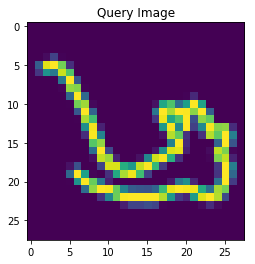

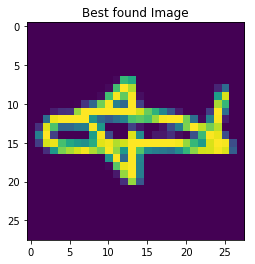

In [74]:
img = X_test[0].reshape([28,28])*255
plt.imshow(img)
plt.title('Query Image')
plt.show()
img = X_train[ind].reshape([28,28])*255
plt.imshow(img)
plt.title('Best found Image')
plt.show()